# N.6. : Détection des contours par filtrage 

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## I. Rappel sur l'approche de dérivation

* Approche gradient : détermination des extréma locaux dans la direction du gradient.
* Approche laplacien : détermination des passages par zéro du laplacien (oou du changement des signes de deux pixels adjacents en y, x).

L'inconvénient de cette approche est qu'elle est très sensible aux bruits (un point bruité isolé peut devenir un point de contour).

## II.

Un autre type d'approche repose sur la définition de critères d'optimalité de la détection de contours. Ces critères débouchent sur des **filtres optimaux**.

Les critères d'optimalité sont :
* Bonne détection : le contour doit être détecté, il faut minimiser les fausses détections.
* Bonne location : le contour doit être localisé avec précision, il s'agit de minimiser la distance entre les points détectés et le vrai contour.
* Unicité de réponse : il s'agit de minimiser le nombre de réponse pour un seul contour.

Exemples des méthodes de cette approche :

* 1. Filtre Canny
* 2. Filtre de Shen-Castan
* 3. Filtre de Deriche
* 4. Filtre Gaussien, Différence de Gaussiens (DOG)

## III. Travail demandé

**1.** Choisir un des filtres optimaux

*Réponse : Pour ce travail nous étudierons le filtre de Canny.*

**2.** Ecrire les formules mathématiques de ce filtre.

*Réponse :*

*Etape 1.* Réduction du bruit avant de détecter les contours. Une façon de faire est d'utiliser un filtre gaussien d'une taille ($2k+1$, $2k+1$) avec $k \in \mathbb{N}$ définit de la manière suivante :

$$
G_{i, j} = \frac{1}{2\pi\sigma^{2}} exp\left(-\frac{(i-(k+1))^{2}+(j - (k+1))^{2}}{2\sigma^{2}}\right)
$$



In [2]:
# Loads a grayscaled image
original_img = cv2.imread("./data/lena.jpg")
img = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)

In [3]:
# Step 1 : Noise Reduction
def gaussian_kernel(size, sigma):
    """ Returns a Gaussian kernel.
    Parameters
    ----------
    size: int
        The size of the kernel i.e. kernel.shape = (size, size).
    sigma: float
        The sigma parameter in the Gaussian formula.
    """
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    coef = (1/(2*np.pi*(sigma**2)))
    kernel = coef * np.exp(
        -((x**2) + (y**2))/(2*(sigma**2))
    )
    return kernel


&lt;matplotlib.image.AxesImage at 0x7f0cad8e3e20&gt;

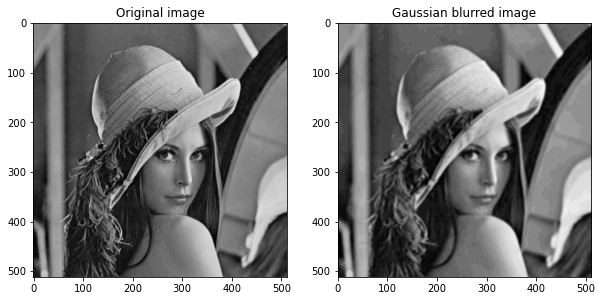

In [4]:
blurred_img = cv2.filter2D(img, -1, gaussian_kernel(5, 6))

fig, axs = plt.subplots(1, 2, figsize=(10,10))

axs[0].set_title("Original image")
axs[0].imshow(img, cmap=plt.cm.gray)
axs[1].set_title("Gaussian blurred image")
axs[1].imshow(blurred_img, cmap=plt.cm.gray)

*Etape 2.* Calculer le gradient permet de détecter les variations d'intensité dans l'image ainsi que leur direction. Pour cela, nous allons utiliser les filtres de Sobel qui permettent de détecter ces variations verticalement en horizontalement.

$$
S_{x} = 
\begin{pmatrix}
-1 & 0 & 1 \\
-2 & 0 & 2 \\
-1 & 0 & 1
\end{pmatrix}
\ \ 
S_{y} = 
\begin{pmatrix}
1 & 2 & 1 \\
0 & 0 & 0 \\
-1 & -2 & -1
\end{pmatrix}
$$

Le gradient de l'image est donné par la formule suivante :
$$
G = \sqrt{G_{x}^{2}+G_{y}^{2}}\ \ avec \ \ 
G_{x} = I * S_{x} \ \ et\ \ 
G_{y} = I * S_{y} \\
\theta = arctan\left(\frac{G_{y}}{G_{x}}\right)
$$

In [5]:
# Step 2 : Gradient Calculation
def sobel_filters(img):
    """ Filters an image using sobel filters
    """
    vertical_sobel = np.array([
        [-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1]
    ])
    horizontal_sobel = np.array([
        [1, 2, 1],
        [0, 0, 0],
        [-1, -2, -1]
    ])

    v_img = cv2.filter2D(img, -1, vertical_sobel)
    h_img = cv2.filter2D(img, -1, horizontal_sobel)

    magnitude = np.sqrt(v_img**2 + h_img**2)
    slope = np.arctan2(h_img, v_img)

    return(magnitude.astype(np.uint8), slope)

&lt;matplotlib.image.AxesImage at 0x7f0cac772f40&gt;

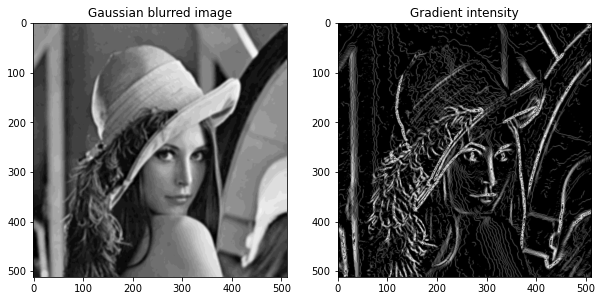

In [6]:
gradient_intensity, slope = sobel_filters(blurred_img)

fig, axs = plt.subplots(1, 2, figsize=(10, 10))

axs[0].set_title("Gaussian blurred image")
axs[0].imshow(blurred_img, cmap=plt.cm.gray)
axs[1].set_title("Gradient intensity")
axs[1].imshow(gradient_intensity, cmap=plt.cm.gray)

*Etape 3.* Supprimer les valeurs non-maximales de notre gradient nous permettrons d'obtenir des contours nets dans notre gradient d'intensité. En effet, notre objectif est d'obtenir une image binaire et non une image de niveau de gris.

...